In [280]:
from model import DenoisingUNet
from utils import *
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn

In [281]:
N_sub = 11
samp = 50.
hidden_layers = 4

## Load Trained Model

In [282]:
criterion = nn.MSELoss()
model_name = "DAS-1"
model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
# state = torch.load(f'../data/runs/synthetic-run/DAS-SANTORINI-runs/{model_name}.pth')
state = torch.load(f'../data/runs/synthetic-run/DAS-SANTORINI-runs/checkpoints/checkpoint-6.pth')
model.load_state_dict(state['model_state_dict'])
model.eval();

In [283]:
# print("Hyperparameters used for this model are: ")
# with open(f'../data/runs/synthetic-run/DAS-SANTORINI-runs/{model_name}.txt') as f:
#     print(f"\n {f.read()}")

## Get J-Invariant Reconstructions

In [284]:
def cc_gain(sample,reconstruction,bin_size=11):
    og = np.array(sample)
    rec = np.array(reconstruction)
    cc_og = compute_moving_coherence(og, bin_size)
    cc_rec = compute_moving_coherence(rec, bin_size)
    gain = cc_rec / cc_og
    return gain 
    
def j_reconstruct(model, data, N_sub=11):
    N_ch = data.shape[0]
    N_t = data.shape[1]
    eval_sample = np.zeros_like(data)
    t_slice = slice(N_t//4, 3*N_t//4)

    """ Prepare samples and masks """
    masks = np.ones((N_ch, N_sub, N_t))
    eval_samples = np.zeros_like(masks)
    # Loop over data and normalise
    for i, wv in enumerate(data):
        eval_sample[i] = wv / wv[t_slice].std()
    gutter = N_sub // 2
    mid = N_sub // 2

    for i in range(gutter):
        masks[i, i] = 0
        eval_samples[i, :, :] = eval_sample[:N_sub]

    for i in range(gutter, N_ch - gutter):
        start = i - mid
        stop = i + mid if N_sub % 2 == 0 else i + mid + 1

        masks[i, mid] = 0
        eval_samples[i, :, :] = eval_sample[start:stop]

    for i in range(N_ch - gutter, N_ch):
        masks[i, i - N_ch] = 0
        eval_samples[i, :, :] = eval_sample[-N_sub:]

    sample = eval_samples * masks
    sample = torch.unsqueeze(torch.Tensor(sample).squeeze(), 1)
    c_mask = (1-masks)
    output = model(sample).detach().squeeze()*c_mask
    output = output.sum(axis=1)
    output_ = taper_filter(output, 1, 10, samp)
    return data, output, output_

## Load Data:

In [285]:
val_path = "../data/santorini-DAS/train"
val_files = glob(os.path.join(val_path, '*.npy'))

## Results

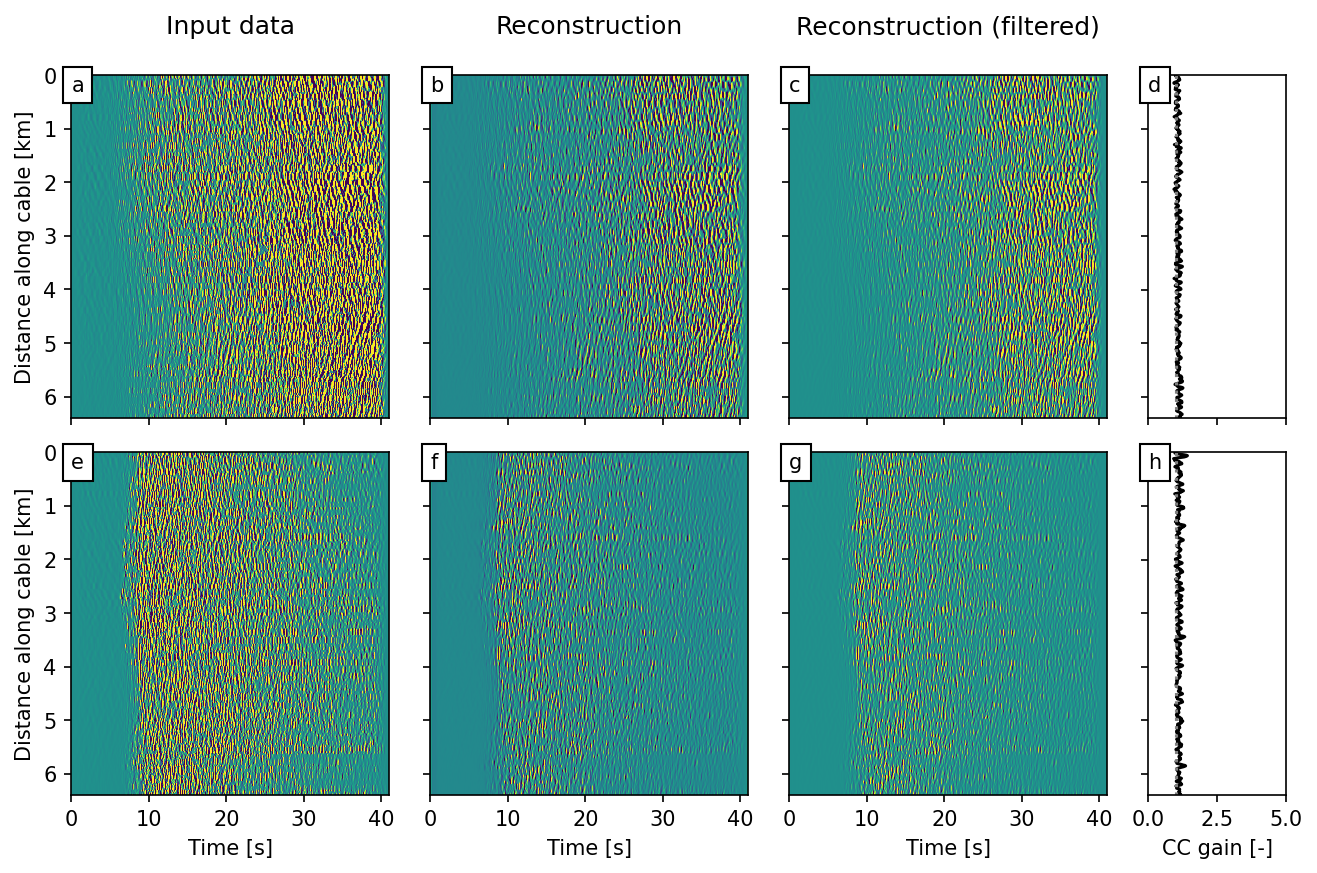

In [286]:
event_high = 13
event_low = 1
high = np.load(val_files[event_high])
low = np.load(val_files[event_low])
Nch, Nt = high.shape
data_high = np.zeros_like(high)
data_low = np.zeros_like(low)
t_slice = slice(Nt//4, 3*Nt//4)


# Loop over data and normalise
for i, wv in enumerate(high):
    data_high[i] = wv / wv[t_slice].std()

# Loop over data and normalise
for i, wv in enumerate(low):
    data_low[i] = wv / wv[t_slice].std()

gauge = 8.
dist = np.arange(Nch) * gauge * 1e-3

imshow_params = {
    "vmin": -0.5,
    "vmax": 0.5,
    "aspect": "auto",
    "interpolation": "antialiased",
    "cmap": "viridis",
    "extent": [0, Nt/samp, Nch*gauge*1e-3, 0],
    "rasterized": True,
}

letters = "abcdefghijk"
letter_params = {
    "fontsize": 10,
    "verticalalignment": "top",
    "bbox": {"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
}



# get reconstructions
eval_sample_high, reco_high, reco_high_filtered = j_reconstruct(model, data_high)
cc_high = cc_gain(eval_sample_high, reco_high_filtered)

eval_sample_low, reco_low, reco_low_filtered = j_reconstruct(model, data_low)
cc_low = cc_gain(eval_sample_low, reco_low_filtered)


# Draw canvas
fig = plt.figure(figsize=(9, 6), dpi=150)
gs = fig.add_gridspec(2, 7)

axes = []

""" Panel a """
ax = fig.add_subplot(gs[0, 0:2])
axes.append(ax)
ax.imshow(eval_sample_high, **imshow_params)
ax.set_ylabel("Distance along cable [km]")
ax.set_title("Input data", pad=20)
ax.xaxis.set_ticklabels([])

""" Panel b """
ax = fig.add_subplot(gs[0, 2:4])
axes.append(ax)
ax.imshow(reco_high, **imshow_params)
ax.set_title("Reconstruction", pad=20)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

""" Panel c """
ax = fig.add_subplot(gs[0, 4:6])
axes.append(ax)
ax.imshow(reco_high_filtered, **imshow_params)
ax.set_title("Reconstruction (filtered)", pad=20)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

""" Panel d """
ax = fig.add_subplot(gs[0, -1])
axes.append(ax)
ax.plot(cc_high, dist, c="k")
ax.axvline(1, ls=":", c="gray")
ax.set_xlim((0, 5))
ax.set_ylim((dist.max(), dist.min()))
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])

""" Panel e """
ax = fig.add_subplot(gs[1, 0:2])
axes.append(ax)
ax.imshow(eval_sample_low, **imshow_params)
ax.set_ylabel("Distance along cable [km]")
ax.set_xlabel("Time [s]")

""" Panel f """
ax = fig.add_subplot(gs[1, 2:4])
axes.append(ax)
ax.imshow(reco_low, **imshow_params)
ax.set_xlabel("Time [s]")
ax.yaxis.set_ticklabels([])

""" Panel g """
ax = fig.add_subplot(gs[1, 4:6])
axes.append(ax)
ax.imshow(reco_low_filtered, **imshow_params)
ax.set_xlabel("Time [s]")
ax.yaxis.set_ticklabels([])

""" Panel h """
ax = fig.add_subplot(gs[1, -1])
axes.append(ax)
ax.plot(cc_low, dist, c="k")
ax.axvline(1, ls=":", c="gray")
ax.set_xlim((0, 5))
ax.set_ylim((dist.max(), dist.min()))
ax.yaxis.set_ticklabels([])
ax.set_xlabel("CC gain [-]")

# Add panel letters
for i, ax in enumerate(axes):
    ax.text(x=0.0, y=1.0, transform=ax.transAxes, s=letters[i], **letter_params)
    
# Adjust panel positions
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.07, right=0.97, hspace=0.1, wspace=0.3)

# plt.savefig("figures/HCMR_data.pdf")
plt.show()

## Wiggle for Wiggle Comparison

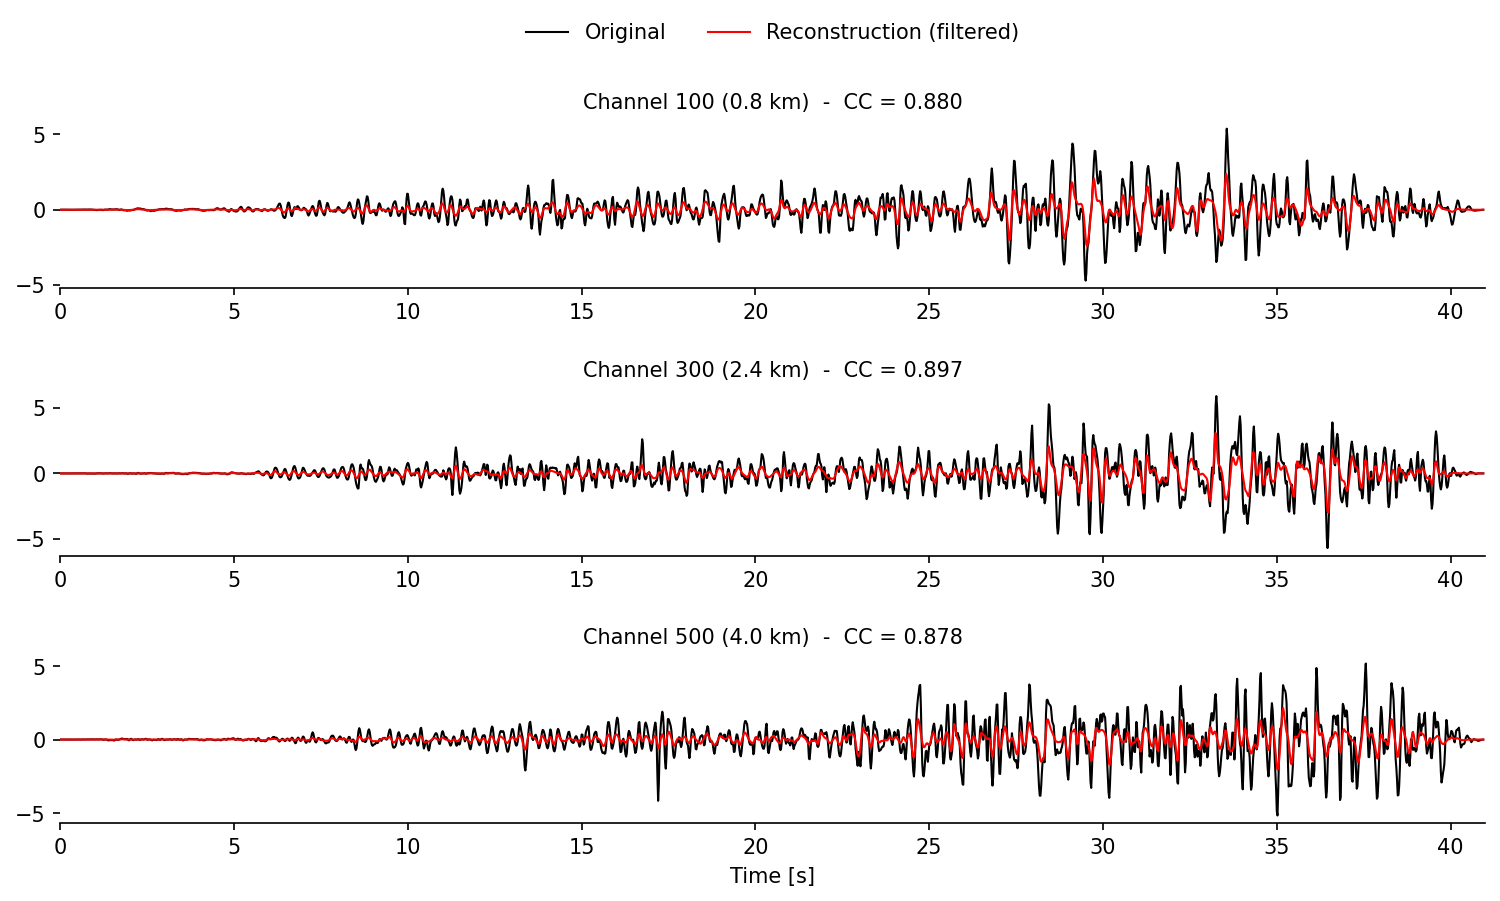

In [287]:
# Selection of channels
selection = (100, 300, 500)
# Define time window
tmin = 0
tcor = 25
tmax = 41
t = np.arange(Nt) / samp

start = np.argmin(np.abs(t-tcor))
end = np.argmin(np.abs(t-tmax))
t_slice = slice(start, end)

# Draw canvas
fig, axes = plt.subplots(nrows=3, figsize=(10, 6),dpi=150)

# Loop over selected channels
for i, n in enumerate(selection):
    ax = axes[i]
    
    # Compute CC
    CC = pearsonr(eval_sample_high[n,t_slice], reco_high_filtered[n,t_slice])[0]
    
    # Plot wiggles
    ax.plot(t, eval_sample_high[n], "k", lw=1.0, label="Original")
    ax.plot(t, reco_high_filtered[n], "r", lw=1.0, label="Reconstruction (filtered)")
    ax.set_xlim((tmin, tmax))
    # ax.set_yticks([])
    
    # Indicate channel and CC
    ax.set_title("Channel %d (%.1f km)  -  CC = %.3f" % (n, n * gauge * 1e-3, CC), fontsize=10)
    for spine in ("top", "left", "right"):
        ax.spines[spine].set_visible(False)

# Add x-axis label
ax.set_xlabel("Time [s]")

# Add legend
axes[0].legend(ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1.7), frameon=False)

# Adjust subplots
plt.subplots_adjust(top=0.87, bottom=0.09, left=0.02, right=0.97, hspace=0.6)
plt.show()